In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from models.prim import PrimClassifier

from utils.data_loader import load_metadata, load_betas
from utils.colors import DTU_COLOR_HEX, DTU_BIN, DTU_BIN_HC


colors = list(DTU_COLOR_HEX.values())
sns.set_palette(sns.color_palette(colors))

In [12]:
ACTIVITY = 'LeisureT'
THRESHOLD = 7900
betas_dp = load_betas('dp')
names = list(betas_dp.keys())[:-1]

In [31]:
def create_cube_counts(filename:str):
    data = pd.read_csv(f'data/out/{filename}.csv')
    # data = pd.read_csv('qd_results_32.csv')
    data = data.drop(['Unnamed: 0'], axis=1)
    # data_standardized = (data - data.mean()) / data.std()
    cube = data[names]
    counts = data[ACTIVITY]
    return cube, counts

In [32]:
data = pd.read_csv(f'data/out/LHS/1685970373.084523.csv')
# data = pd.read_csv('qd_results_32.csv')
data = data.drop(['Unnamed: 0'], axis=1)
# data_standardized = (data - data.mean()) / data.std()
cube_lhs = data[names]
counts_lhs = data[ACTIVITY]

In [33]:
# cube, counts = create_cube_counts('qd_100')

In [34]:
def get_limits(cube, counts):
    pc = PrimClassifier(
        activity = ACTIVITY,
        threshold = THRESHOLD,
        peel_alpha=0.1
    )
    box = pc.fit(cube, counts)
    limits = box.limits
    return limits

def get_distance(limits, base):
    df = base.join(limits, lsuffix='_base', how='outer')
    df = df.fillna(0)
    df['distance'] = (df['min'] - df['min_base'])**2 + (df['max'] - df['max_base'])**2
    return np.sqrt(df['distance'].sum())

In [35]:
N_POINTS = 10
distance = np.empty(N_POINTS)

extra_points = np.linspace(0,600,N_POINTS)
extra_points = [round(item) for item in extra_points]

def get_distance_array(cube, counts, init_size:int):
    for iter, item in enumerate(extra_points):
        limits_lhs = get_limits(cube_lhs.iloc[:(init_size+item)],counts_lhs.iloc[:(init_size+item)])
        limits = get_limits(cube.iloc[:(100+item)],counts.iloc[:(100+item)])
        distance[iter] = get_distance(limits, limits_lhs)
    return distance

In [36]:
SIZES = 100 * np.array(range(1,10))
DISTANCE = np.empty((10,N_POINTS))
AVG_DISTANCE = np.empty(10)
for iter, size in enumerate(SIZES):
    cube, counts = create_cube_counts(f"BO/ax_beta100_{size}")
    DISTANCE[iter] = get_distance_array(cube, counts, size)
    AVG_DISTANCE[iter] = distance.mean()

Text(50.722222222222214, 0.5, 'Initial dataset size')

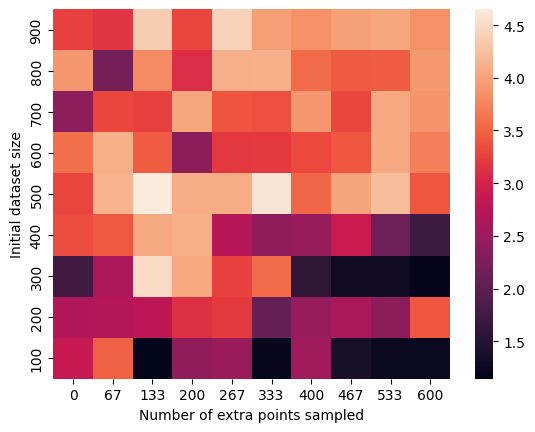

In [37]:
df_distance = pd.DataFrame(DISTANCE[:9], index=SIZES, columns=extra_points)
df_distance = df_distance.sort_index(ascending=False)
sns.heatmap(df_distance)
plt.xlabel('Number of extra points sampled')
plt.ylabel('Initial dataset size')

In [38]:
FIRST_BELOW_AVG = [((DISTANCE[i] < AVG_DISTANCE[i]).argmax() + 1) * 100 for i in range(10)]